In [25]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import regdata as rd
from copy import deepcopy

import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import optax
import jaxopt

import matplotlib.pyplot as plt

from gpax.core import Parameter
from gpax.models import ExactGPRegression, SparseGPRegression
from gpax.kernels import RBF, GibbsHeinonen, GibbsDeltaInducing
from gpax.means import Scalar, Average
from gpax.likelihoods import Gaussian, HeteroscedasticHeinonen, HeteroscedasticDeltaInducing
from gpax.utils import train_fn
from gpax.plotting import plot_posterior

from sklearn.preprocessing import MinMaxScaler

import pprint
pp = pprint.PrettyPrinter(depth=4)

is_parameter = lambda x: isinstance(x, Parameter)

jax.config.update("jax_enable_x64", True)

(94, 1) (94,) (188, 1)


(0.9999999999999999, 0.0, 2.4485507246376805, -1.151449275362319)

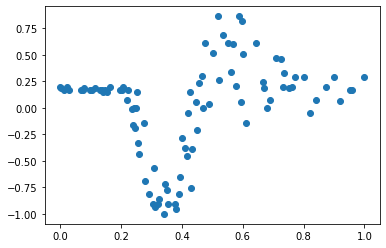

In [26]:
X, y, X_test = rd.MotorcycleHelmet().get_data()
idx = jnp.argsort(X, axis=0)
X, y = X[idx, 0], y[idx][:, 0]
X_test = jnp.sort(X_test, axis=0)
X_test = X_test * 3.0
print(X.shape, y.shape, X_test.shape)

xscaler = MinMaxScaler()
X = xscaler.fit_transform(X)
X_test = xscaler.transform(X_test)
yscale = jnp.max(jnp.abs(y - jnp.mean(y)))
ymean = jnp.mean(y)
y = (y - ymean) / yscale

plt.scatter(X, y);
X.max(), X.min(), X_test.max(), X_test.min()

## Exact GP

In [32]:
kernel_type = GibbsDeltaInducing  # GibbsDeltaInducing, GibbsHeinonen
likelihood_type = HeteroscedasticDeltaInducing # HeteroscedasticDeltaInducing, HeteroscedasticHeinonen
gp_type = ExactGPRegression  # SparseGPRegression, ExactGPRegression

X_inducing.shape=(10, 1)


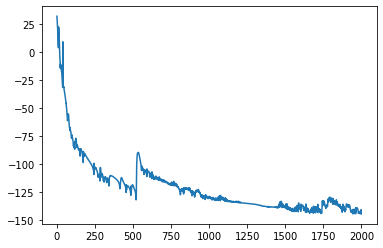

In [36]:
X_inducing = X[::10]  # X, X[::10]
print(f"{X_inducing.shape=}")

kernel = kernel_type(flex_lengthscale=True, flex_scale=True, X_inducing=X_inducing, latent_lengthscale_ell=0.2, latent_lengthscale_sigma=1.0, latent_scale_ell=0.2, latent_scale_sigma=1.0)
likelihood = likelihood_type(X_inducing=X_inducing, latent_gp_lengthscale=0.3, latent_gp_scale=1.0)
model = gp_type(kernel, likelihood, Average(), X_inducing)

def loss_fun(raw_params):
    model.set_raw_parameters(raw_params)
    return -model.log_probability(X, y).sum()

optimizer = optax.adam(learning_rate=0.005)
n_iters = 2000

init_key = jax.random.PRNGKey(40)
raw_params = model.initialize(init_key)

result = train_fn(loss_fun, raw_params, optimizer, n_iters=n_iters)

plt.plot(result["loss_history"]);

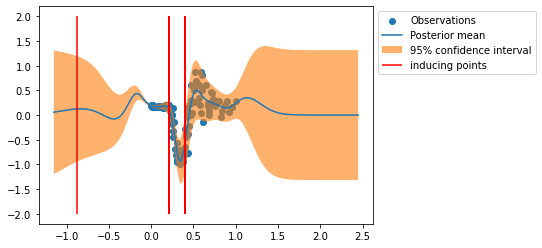

In [37]:
model.set_raw_parameters(result["raw_params"])
pred_mean, pred_cov = model.predict(X, y, X_test)

ax = plot_posterior(X, y, X_test, pred_mean, pred_cov, ax=None, alpha=0.6);
ax.vlines(model.X_inducing(), ymin=-2, ymax=2, color="red", label="inducing points")
ax.legend(bbox_to_anchor=(1.5,1));

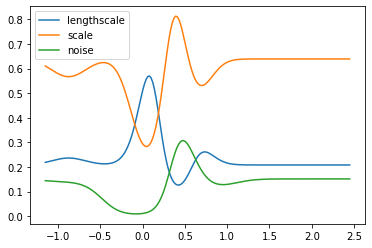

In [38]:
plt.plot(X_test, model.kernel.ls_gp(model.X_inducing())(X_test), label="lengthscale")
plt.plot(X_test, model.kernel.scale_gp(model.X_inducing())(X_test), label="scale")
plt.plot(X_test, model.likelihood.latent_gp(model.X_inducing())(X_test), label="noise")
plt.legend();